In [73]:
import torch
import torchvision
import sys, os
config_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(config_path)
import config
import sklearn as sk
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms



In [74]:
# Load MNIST as tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def preprocess_mnist(dataset):
    data = dataset.data.float().div(255.0).unsqueeze(1)  # scale to [0, 1]
    targets = dataset.targets
    dataset = TensorDataset(data, targets)
    return torch.utils.data.TensorDataset(data, targets)

# Download + preprocess once
raw_train = datasets.MNIST(root=config.DATA_DIR, train=True, download=True)
raw_test = datasets.MNIST(root=config.DATA_DIR, train=False, download=True)

train_dataset = preprocess_mnist(raw_train)
test_dataset = preprocess_mnist(raw_test)

In [75]:
# Set hyperparameters

learning_rate = .02
total_epochs = 100
batch_size = 5000
dropout_probability = 0.2
print(f'training on device: {device}')

training on device: cuda


In [76]:
# Create Dataloader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, shuffle=False, num_workers=0)

In [ ]:
# Create Model
class MNISTnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [B, 1, 28, 28] -> [B, 32, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2),                            # -> [B, 32, 14, 14]

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> [B, 64, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> [B, 64, 7, 7]

            nn.Flatten(),                                # -> [B, 64*7*7]
            nn.Dropout(p=dropout_probability),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(64,10)
        )

    def forward(self, x):
        return self.net(x)

model = MNISTnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_array = []

In [ ]:
# Training loop
def training_loop():
    last_avg = 0
    for epoch in range(1, total_epochs+1):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss  = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            loss_array.append(loss.item())
        if epoch % 10 == 0:
            avg = epoch_loss / len(train_loader)
            if abs(last_avg-avg) <= .05 and avg <= .015:    # Early stopping if loss is no longer improving
                print(f'difference is {abs(last_avg-avg)}')
                print(f"Early stopping at epoch {epoch:5d}")
                break
            print(f"Epoch {epoch:5d} — avg batch loss: {avg:.4f}")
            last_avg = avg


In [79]:
training_loop()

Epoch    10 — avg batch loss: 0.0837
Epoch    20 — avg batch loss: 0.0518
Epoch    30 — avg batch loss: 0.0365
Epoch    40 — avg batch loss: 0.0306
Epoch    50 — avg batch loss: 0.0266
Epoch    60 — avg batch loss: 0.0252
Epoch    70 — avg batch loss: 0.0234
Epoch    80 — avg batch loss: 0.0222
Epoch    90 — avg batch loss: 0.0216
Epoch   100 — avg batch loss: 0.0208


In [80]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Switch to eval+no-grad
model.eval()
with torch.no_grad():
    # Extract all test inputs & labels
    # (TensorDataset stores them in .tensors)
    X_test = test_dataset.tensors[0].to(device)      # shape [10000, 784]
    y_test = test_dataset.tensors[1].cpu().numpy()   # shape [10000,]

    # Forward pass
    logits = model(X_test)                           # [10000, 10]
    preds = torch.argmax(logits, dim=1).cpu().numpy()

# Accuracy
accuracy = (preds == y_test).mean() * 100
print(f"Accuracy: {accuracy:.4f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, preds)
print("\nClassification Report:")
print(class_report)


Accuracy: 99.2600%
Confusion Matrix:
[[ 977    0    1    0    0    0    0    1    1    0]
 [   0 1132    1    0    0    0    1    1    0    0]
 [   3    0 1023    1    0    0    0    4    1    0]
 [   0    0    0 1005    0    4    0    0    1    0]
 [   0    0    1    0  978    0    1    1    0    1]
 [   0    0    0    3    0  888    1    0    0    0]
 [   4    3    0    1    3    1  943    0    3    0]
 [   0    0    5    0    0    0    0 1021    1    1]
 [   0    0    1    0    0    2    0    0  969    2]
 [   0    0    1    0    9    2    0    4    3  990]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      1.00      0.99       892
           6       1.00      

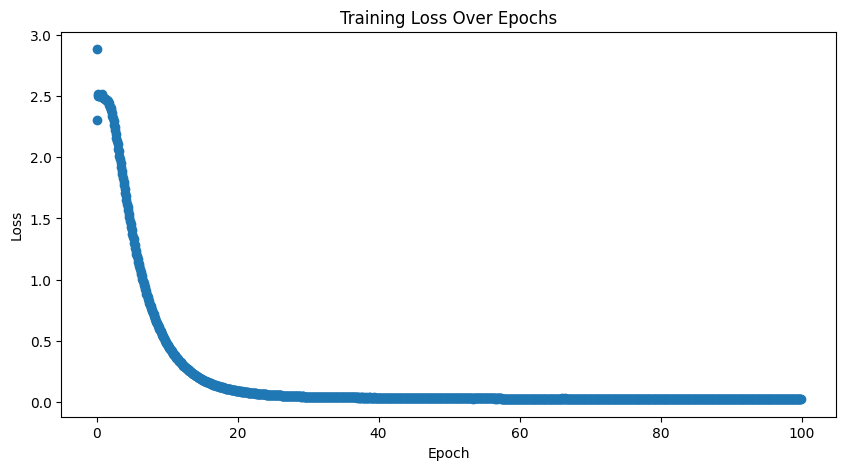

In [81]:
loss_array_epochs = [i/12 for i in range(len(loss_array))]
for i in range (len(loss_array)):
    loss_array[i] = np.mean(loss_array[max(0,i-9):i+1])

plt.figure(figsize = (10,5))
plt.plot(loss_array_epochs, loss_array, marker = 'o', linestyle = '')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(False)
plt.show()

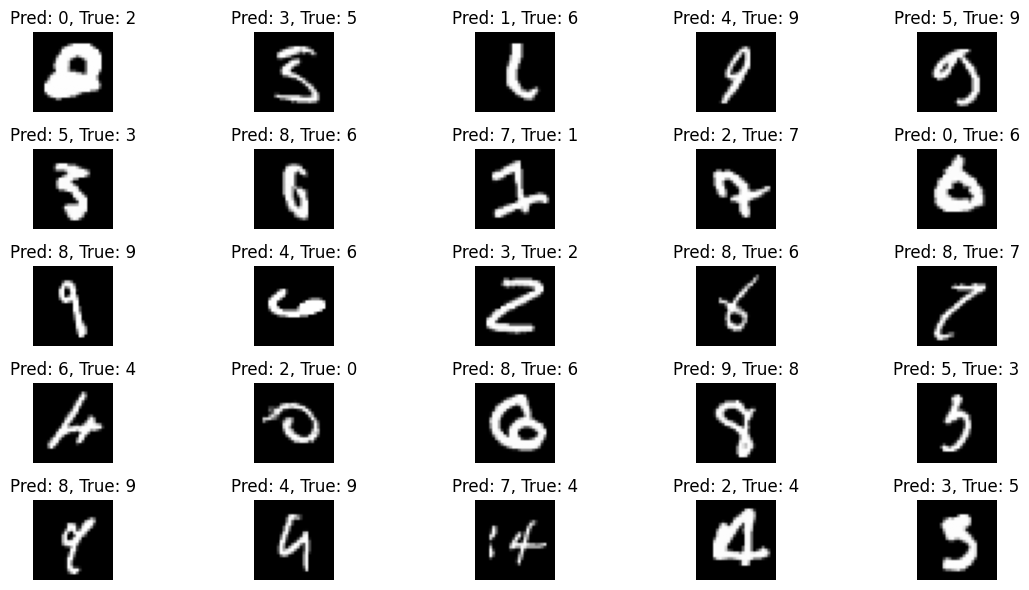

In [82]:
# Find misclassified examples
misclassified_indices = np.where(preds != y_test)[0]

# Number of images to display
num_images = 25

# Plot misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified_indices[25:25+num_images]):
    image = test_dataset.tensors[0][idx].view(28, 28).cpu().numpy()
    true_label = y_test[idx]
    predicted_label = preds[idx]

    plt.subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Pred: {predicted_label}, True: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
